In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.preprocessing import image

In [4]:
train_set='Data/train' #loading the training data
val_set='Data/valid'    #loading the validation data
test_set='Data/test'    #loading the testing data


In [5]:
train_datagen = image.ImageDataGenerator(
    rotation_range=15,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    width_shift_range=0.1,
    height_shift_range=0.1
)

val_datagen= image.ImageDataGenerator(    rotation_range=15,
                                          shear_range=0.2,
                                          zoom_range=0.2,
                                          horizontal_flip=True,
                                          fill_mode='nearest',
                                          width_shift_range=0.1,
                                          height_shift_range=0.1)

test_datagen= image.ImageDataGenerator(    rotation_range=15,
                                           shear_range=0.2,
                                           zoom_range=0.2,
                                           horizontal_flip=True,
                                           fill_mode='nearest',
                                           width_shift_range=0.1,
                                           height_shift_range=0.1)

In [6]:
train_generator = train_datagen.flow_from_directory(
    train_set,
    target_size = (224,224),
    batch_size = 8,
    class_mode = 'categorical')

test_generator = test_datagen.flow_from_directory(
    val_set,
    target_size = (224,224),
    batch_size = 8,
    shuffle=True,
    class_mode = 'categorical')

validation_generator = test_datagen.flow_from_directory(
    test_set,
    target_size = (224,224),
    batch_size = 8,
    shuffle=True,
    class_mode = 'categorical')

Found 613 images belonging to 4 classes.
Found 72 images belonging to 4 classes.
Found 315 images belonging to 4 classes.


In [7]:
base_model = tf.keras.applications.EfficientNetB2(weights='imagenet', input_shape=(224,224,3), include_top=False)
#hyper-parameter
for layer in base_model.layers:
    layer.trainable=False
model = Sequential()
model.add(base_model)
model.add(GaussianNoise(0.25))
model.add(GlobalAveragePooling2D())
model.add(Dense(256,activation='relu'))
model.add(BatchNormalization())
model.add(GaussianNoise(0.25))
model.add(Dropout(0.25))
model.add(Dense(4, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb2 (Functional  (None, 7, 7, 1408)        7768569   
 )                                                               
                                                                 
 gaussian_noise (GaussianNo  (None, 7, 7, 1408)        0         
 ise)                                                            
                                                                 
 global_average_pooling2d (  (None, 1408)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 256)               360704    
                                                                 
 batch_normalization (Batch  (None, 256)               1024      
 Normalization)                                         

In [8]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy','AUC','Precision','Recall'])

In [15]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
es=EarlyStopping(patience=3,monitor='val_loss')
filepath='best_model.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
history = model.fit(
    train_generator,
    epochs=24,
    validation_data=validation_generator,
    steps_per_epoch= 75,
    callbacks=checkpoint
)

RuntimeError: You must compile your model before training/testing. Use `model.compile(optimizer, loss)`.

In [9]:
#loading the train_loss
train_loss = history.history['loss']
train_accuracy = history.history['accuracy']
#loading the valuationLoss
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

NameError: name 'history' is not defined

40/40 [==============================] - 17s 374ms/step


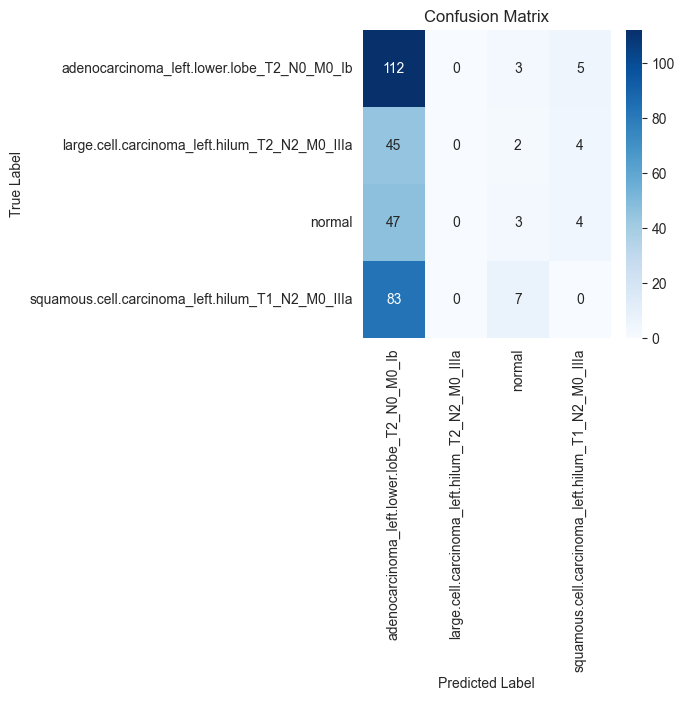

In [17]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get predictions for the validation set
y_true = validation_generator.classes
y_pred = model.predict(validation_generator).argmax(axis=1)

# Create confusion matrix
conf_mat = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(4, 4))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=train_generator.class_indices,
            yticklabels=train_generator.class_indices)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

40/40 [==============================] - 19s 470ms/step


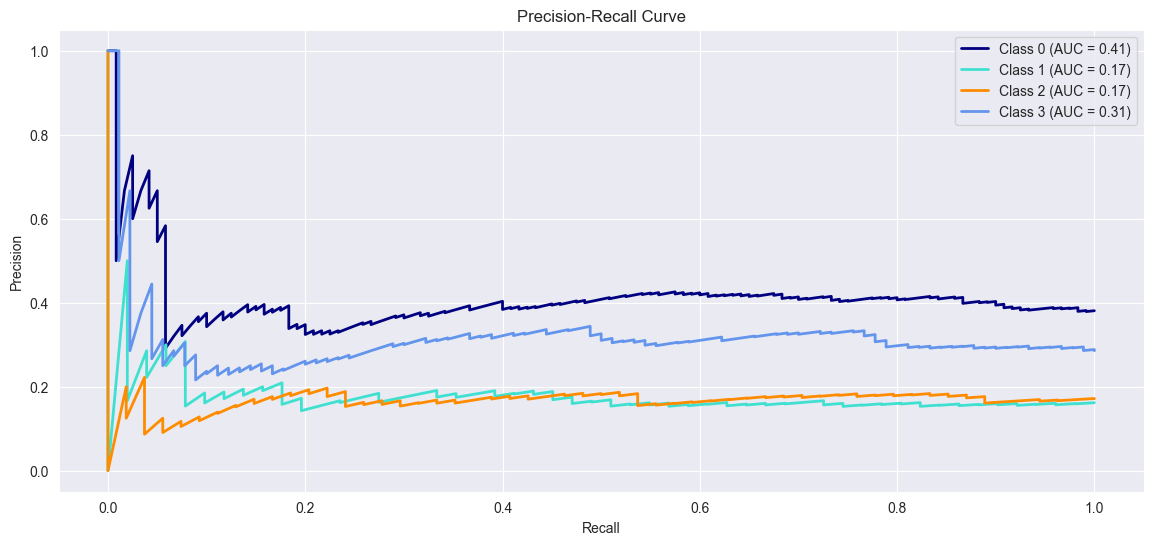

In [18]:
from sklearn.metrics import precision_recall_curve, auc
from itertools import cycle

# Get one-hot encoded true labels and predicted probabilities
y_true_onehot = tf.keras.utils.to_categorical(y_true, num_classes=4)
y_pred_probs = model.predict(validation_generator)

# Plot precision-recall curve for each class
plt.figure(figsize=(14, 6))
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(4), colors):
    precision, recall, _ = precision_recall_curve(y_true_onehot[:, i], y_pred_probs[:, i])
    auc_score = auc(recall, precision)
    plt.plot(recall, precision, color=color, lw=2,
             label=f'Class {i} (AUC = {auc_score:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.show()

In [9]:
model.evaluate(train_generator)

RuntimeError: You must compile your model before training/testing. Use `model.compile(optimizer, loss)`.

training accuracy : 93.31
precision score :93.57

In [23]:
model.evaluate(validation_generator)

RuntimeError: You must compile your model before training/testing. Use `model.compile(optimizer, loss)`.

training accuracy : 78.73
precision score :80.40

In [22]:
model.evaluate(test_generator)

RuntimeError: You must compile your model before training/testing. Use `model.compile(optimizer, loss)`.

training accuracy : 79.17
precision score :80

1/1 [==============================] - 2s 2s/step
[[0.36471683 0.19988048 0.08093634 0.35446638]]
THE UPLOADED IMAGE IS SUSPECTED AS: Adenocarcinoma


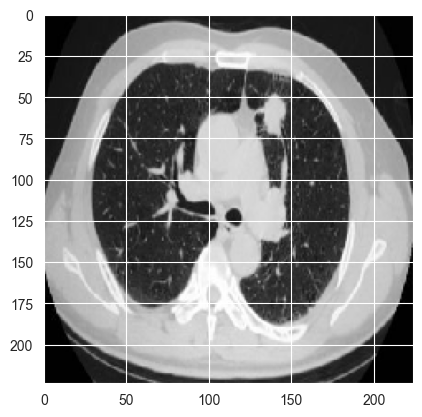

In [10]:
from keras.preprocessing import image
img = image.load_img('lung-scan-article-s.jpg',target_size=(224,224))
imag = image.img_to_array(img)
imaga = np.expand_dims(imag,axis=0)
ypred = model.predict(imaga)
print(ypred)
a=np.argmax(ypred,-1)
if a==0:
    op="Adenocarcinoma"
elif a==1:
    op="large cell carcinoma"
elif a==2:
    op="normal and he will live a very long life"
else:
    op="squamous cell carcinoma"
plt.imshow(img)
print("THE UPLOADED IMAGE IS SUSPECTED AS: "+str(op)) 

In [1]:
!nvidia-smi

Fri Mar 15 21:20:08 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 551.61                 Driver Version: 551.61         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3050 ...  WDDM  |   00000000:01:00.0  On |                  N/A |
| N/A   57C    P8              8W /   80W |     597MiB /   4096MiB |      4%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----